In [111]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
import keras
from keras.layers import LSTM, Dense, Dropout, LeakyReLU, GRU
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
sys.path.append(str(Path("../../..").resolve()))
from src.constants import model_data_dir


In [112]:
df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(["Date", "sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_regression.csv").drop(["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)
test_dates = pd.to_datetime(df_test["Date"])
df_test.drop("Date", axis=1, inplace=True)

In [113]:
((y_train, x_train), (y_test, x_test)) = ((df_train.pop("value_1d_fwd_rel_ret"), df_train), (df_test.pop("value_1d_fwd_rel_ret"), df_test))

In [114]:
win_length = 30
batch_size = 90
num_features = x_train.shape[1]
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)


## LSTM

In [115]:
model = Sequential()
model.add(LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.3)) 
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3)) 
model.add(Dense(1))

In [116]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 128)           115712    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 30, 128)           131584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 dropout_8 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)               

In [117]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                        patience = 10)

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer="adam",
              metrics=[keras.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False, callbacks=[early_stop])

Epoch 1/50


/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_20178/2842819395.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=50,


38/38 [==============================] - 13s 149ms/step - loss: 0.0092 - mean_absolute_error: 0.0540 - val_loss: 2.8327e-05 - val_mean_absolute_error: 0.0040
Epoch 2/50
38/38 [==============================] - 4s 99ms/step - loss: 1.3762e-04 - mean_absolute_error: 0.0092 - val_loss: 4.2826e-05 - val_mean_absolute_error: 0.0052
Epoch 3/50
38/38 [==============================] - 4s 117ms/step - loss: 8.4402e-05 - mean_absolute_error: 0.0073 - val_loss: 3.0339e-05 - val_mean_absolute_error: 0.0042
Epoch 4/50
38/38 [==============================] - 4s 105ms/step - loss: 6.6748e-05 - mean_absolute_error: 0.0065 - val_loss: 3.5676e-05 - val_mean_absolute_error: 0.0047
Epoch 5/50
38/38 [==============================] - 5s 128ms/step - loss: 5.5453e-05 - mean_absolute_error: 0.0060 - val_loss: 2.6785e-05 - val_mean_absolute_error: 0.0038
Epoch 6/50
38/38 [==============================] - 5s 127ms/step - loss: 5.1512e-05 - mean_absolute_error: 0.0057 - val_loss: 2.6686e-05 - val_mean_absolu

In [118]:
predictions = model.predict_generator(test_generator)
df_preds = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds["yhat"] = predictions.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_20178/953353012.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


<AxesSubplot:>

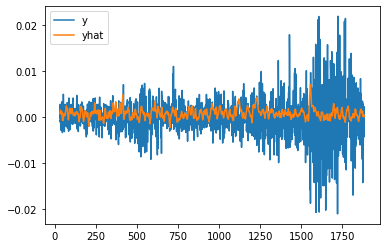

In [119]:
df_preds[["y", "yhat"]].plot()

## GRU 

In [120]:
model_gru = Sequential()
model_gru.add(GRU(128, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(Dropout(0.3)) 
model_gru.add(GRU(64, return_sequences=False))
model_gru.add(Dropout(0.3)) 
model_gru.add(Dense(1))

In [121]:
model_gru.compile(loss=keras.losses.MeanSquaredError(),
              optimizer="adam",
              metrics=[keras.metrics.MeanAbsoluteError()])

history_gru = model_gru.fit_generator(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False, callbacks=[early_stop])

Epoch 1/50


/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_20178/3841558504.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gru = model_gru.fit_generator(train_generator, epochs=50,


38/38 [==============================] - 13s 145ms/step - loss: 0.0208 - mean_absolute_error: 0.0916 - val_loss: 1.4631e-04 - val_mean_absolute_error: 0.0095
Epoch 2/50
38/38 [==============================] - 3s 88ms/step - loss: 8.8905e-04 - mean_absolute_error: 0.0238 - val_loss: 1.1060e-04 - val_mean_absolute_error: 0.0083
Epoch 3/50
38/38 [==============================] - 4s 113ms/step - loss: 5.8339e-04 - mean_absolute_error: 0.0191 - val_loss: 9.3129e-05 - val_mean_absolute_error: 0.0076
Epoch 4/50
38/38 [==============================] - 4s 99ms/step - loss: 4.5874e-04 - mean_absolute_error: 0.0169 - val_loss: 6.9782e-05 - val_mean_absolute_error: 0.0066
Epoch 5/50
38/38 [==============================] - 5s 119ms/step - loss: 4.0751e-04 - mean_absolute_error: 0.0161 - val_loss: 5.7847e-05 - val_mean_absolute_error: 0.0060
Epoch 6/50
38/38 [==============================] - 4s 96ms/step - loss: 3.5305e-04 - mean_absolute_error: 0.0149 - val_loss: 5.0152e-05 - val_mean_absolute

In [122]:
predictions_gru = model_gru.predict_generator(test_generator)
df_preds_gru = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds_gru["yhat"] = predictions_gru.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_20178/2811852203.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


<AxesSubplot:>

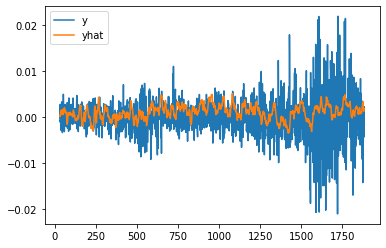

In [123]:
df_preds_gru[["y", "yhat"]].plot()